In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
from getdist import plots, MCSamples
import time
from scipy.stats import multivariate_normal
%matplotlib inline

In [148]:
class log_nor:
    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
        self.detcov = np.linalg.det(cov)
        self.invcov = np.linalg.inv(cov)
        self.k = len(mu)
        self.sqrt = np.log(np.sqrt((2*np.pi)**self.k)*self.detcov)
    
    def pdf(self, x):
        arg = x - self.mu
        self.prob = -0.5*(arg.T)@self.invcov@arg - self.sqrt
        return self.prob

def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # log(pi)
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) - 0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta_hmc(ec, ep, EC, EP, x, X):
    alpha = min(- EP - EC + ep + ec, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return X, EP
    else:
        return x, ep
    
    
def acepta_mh(T1, pos1, T2, pos2, m1, m2):
    alpha = min(pos2 - pos1, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return T2, pos2, m2
    else:
        return T1, pos1, m1    


def modelo(theta, x): 
    return theta[0]*x + theta[1]*x**2


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    print(bol)
    if bol>0:
        a = 0 # raiz imaginaria 
    else:
        a = 1 # raiz real
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0


def potencial(dat, sigma, theta, z):
    mod = modelo(theta, z)
    u = - likelihood(mod, dat, sigma) - prior(theta) 
    return u


def cinetica(p, m):
    k = np.sum(p**2/2/m)
    return k


def hamiltoniano(p, dat, sigma, theta, z, m=1):
    h = cinetica(p, m) + potencial(dat, sigma, theta, z)
    return h


def gradiente(dw, theta, z, dat, sigma):
    tf = theta + dw
    tb = theta - dw
    grad = (potencial(dat, sigma, tf, z) - potencial(dat, sigma, tb, z))/(2*dw)
    return grad


def leapfrog(l, e, dw, theta, m, z, dat, sigma):

    qe = theta
    while True:

        pi = np.random.multivariate_normal(mean=np.zeros(3), cov=np.diag(m))
        pe = pi
        X = []
        P = []
        X.append(theta)
        P.append(pe)
        for i in range(l):
  
            #print(i)
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break            
            #print('ant pe', pe)
            #print('ant qe', qe)
            #print('grad', gradiente(dw, qe, z, dat, sigma))
            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma) # actualiza momento en e/2
            
            #print('desp pe', pe)
            
            qe = qe + e*pe/m
            if qe[0]<0:
                qe[0] = qe[0]*-1
                pe[0] = pe[0]*-1
            if qe[1]<0:
                qe[1] = qe[1]*-1
                pe[1] = pe[1]*-1
            if qe[2]>1/3:
                qe[2] = 1/3 - qe[2]
                pe[2] = pe[2]*-1
      
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break

            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma)

            P.append(pe)
            X.append(qe)
            if i + 1==l: 
                i += 1
        if i==l: 
            break

    P = np.array(P)
    X = np.array(X)
    return X, P
    
    
def HMC(modelo, datos, ds, dg, N, L, params, q0, cov_mod, m, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    pid0 = PID(kp=10, ki=10, kd=10, o_min=1e-4, o_max=1e1)
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    H = []
    acept = 0
    mod1 = modelo(q0, X)
    pos1 = potencial(Y, cov_mod, q0, X)
    Chi1 = chi2(mod1, Y, cov_mod)[0]
    chain.append(q0)
    post.append(pos1)
    chi_2.append(Chi1)
    Ratio.append(100)

    Ti = time.time()
    for i in range(N):
        #error = des - Ratio[-1]/100
        #pid0.set_out(error)
        #m[0] = pid0.out
        q = chain[i]
        while True:
            Q, P = leapfrog(L, ds, dg, q, m, X, Y, cov)
            Q1 = Q[-1]
            P1 = P[-1]
            if revisa1(Q1):
                break
        H.append(Q)
        t = cinetica(P1[0], m)
        u = potencial(Y, cov_mod, q, X)
        T = cinetica(P1, m)
        U = potencial(Y, cov_mod, Q1, X)
        A = acepta_hmc(t, u, T, U, q, Q1)
        chain.append(A[0])
        post.append(A[1])
        mod1 = modelo(A[0], X)
        Chi1 = chi2(mod1, Y, cov_mod)[0]
        chi_2.append(Chi1)
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%10==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')

    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
    H = np.array(H)

    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def MH(modelo, datos, N, params, q0, cov_mod, cov_prop, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    #pid = PID(kp=10, ki=10, kd=10, o_min=2, o_max=20)
    lognor = log_nor(mu=np.zeros(2), cov=np.eye(2))
    T0 = q0
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    mod = []
    acept = 0
    mod0 = modelo(T0, X)
    
    pos0 = lognor.pdf(x=T0)
    mod.append(mod0)
    chain.append(T0)
    post.append(pos0)
    
    Ratio.append(100)

    # pasos de cadena
    Ti = time.time()
    for i in range(N):
        # revisa si se paso umbral de burn in
        """	
        if chi_2[i]<=580 and d==0 and o!=0:
            covarianza = COV[o]
            d = 1
            print('actualizada')
            print(covarianza)
        """	
        # selecciona ultimo elemento de la cadena
        T0 = chain[i]
        T1 = np.random.multivariate_normal(mean=T0, cov=cov_prop)
        # itera hasta que encuentra un proposal valido
        #while True:
         #   T1 = np.random.multivariate_normal(mean=T0, cov=cov_prop)
          #  if revisa1(T1):
           #     break
        # selecciona ultimo modelo
        mod0 = mod[i]
        # calcula modelo con proposal
        mod1 = modelo(T1, X)
        # selecciona ultima dis. post.
        pos0 = post[i]
        # calcula nueva dist. post.
        pos1 = lognor.pdf(x=T1) # likelihood(mod1, Y, cov_mod) + prior(T1)
        # decision de aceptacion
        A = acepta_mh(T0, pos0, T1, pos1, mod1, mod1)
        # guarda la variable aceptada (puede ser la anterior o proposal)
        chain.append(A[0])
        post.append(A[1])
        mod.append(A[2])
        
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%1000==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')
    
    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
  
    Ratio = np.array(Ratio)
  
    t1 = chain[:,0]
    t2 = chain[:,1]
    #t3 = chain[:,2]

    # busca argumento del minimo de chi2
    #t1m, t2m = np.around(argmin2(t1, t2, t3, chi_2),3)
    #mins = [t1m, t2m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, post #, mins

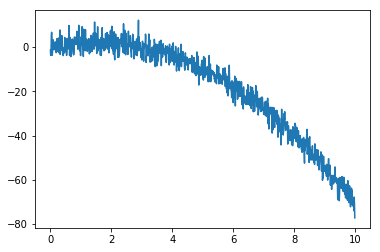

In [113]:
x = np.arange(0, 10, 0.01)
s = 3
y = 3*x - x**2 + np.random.normal(0, s, len(x))
cov = np.eye(len(x))*s**2
plt.plot(x, y)

[0.1 0.1]
q0 [-0.1222532  -0.42850218]
0
ratio 100
1000
ratio 85.39999999999999
Tiempo cadena 1.0 s
ratio % 85.0


Text(0,0.5,'b')

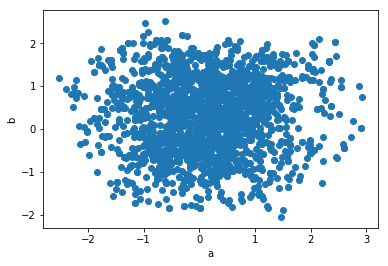

In [153]:
# covarianza inicial
cov_ini = np.eye(2)*1e-1
print(np.diag(cov_ini))
q0 = np.random.uniform(low=[-1, -1], high=[1, 1], size=2)
print('q0', q0)
R_mh = MH(modelo, [x, y], N=2000, params=['a', 'b'], q0=q0, cov_mod=cov, cov_prop=cov_ini)
plt.scatter(R_mh[0]['a'], R_mh[0]['b'])
plt.xlabel('a')
plt.ylabel('b')

(array([ 18.,  69., 169., 341., 452., 455., 309., 111.,  58.,  19.]),
 array([-2.525844  , -1.98103338, -1.43622275, -0.89141212, -0.3466015 ,
         0.19820913,  0.74301975,  1.28783038,  1.83264101,  2.37745163,
         2.92226226]),
 <a list of 10 Patch objects>)

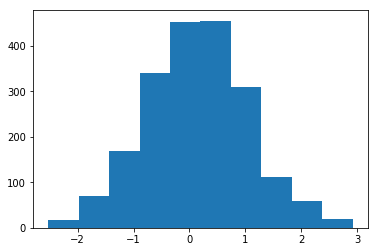

In [154]:
plt.hist(R_mh[0]['a'])

(array([ 29.,  72., 167., 286., 300., 394., 382., 235., 121.,  15.]),
 array([-2.05934468, -1.60135065, -1.14335662, -0.68536259, -0.22736857,
         0.23062546,  0.68861949,  1.14661352,  1.60460755,  2.06260158,
         2.52059561]),
 <a list of 10 Patch objects>)

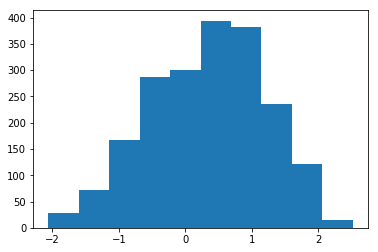

In [155]:
plt.hist(R_mh[0]['b'])

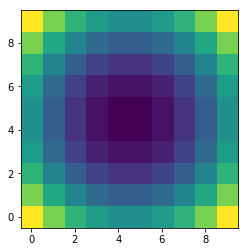

In [157]:
def pot(x):
    return -x

lognor = log_nor(mu=np.zeros(2), cov=np.eye(2))
p = lognor.pdf(x=np.ones(2)*0)
x = np.linspace(-2, 2, 10)
y = np.linspace(-2, 2, 10)
P = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        P[i, j] = pot(lognor.pdf(np.array([x[i], y[j]])))
plt.imshow(P, origin='lower')

In [ ]:
class Leap:
    def __init__(self, l, epsilon, mass, p0):
        self.l = l
        self.epsilon = epsilon
        self.mass = mass
        self.p0 = p0
        self.invmass = np.linalg.inv(self.mass)
    
    def act(self, x):
        p = np.random.normal(0, self.p0, len(x))
        k = 0.5*(p.T)@self.invmass@p
        u = -
        

def leapfrog(l, e, dw, theta, m, z, dat, sigma):

    qe = theta
    while True:

        pi = np.random.multivariate_normal(mean=np.zeros(3), cov=np.diag(m))
        pe = pi
        X = []
        P = []
        X.append(theta)
        P.append(pe)
        for i in range(l):
  
            #print(i)
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break            
            #print('ant pe', pe)
            #print('ant qe', qe)
            #print('grad', gradiente(dw, qe, z, dat, sigma))
            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma) # actualiza momento en e/2
            
            #print('desp pe', pe)
            
            qe = qe + e*pe/m
            if qe[0]<0:
                qe[0] = qe[0]*-1
                pe[0] = pe[0]*-1
            if qe[1]<0:
                qe[1] = qe[1]*-1
                pe[1] = pe[1]*-1
            if qe[2]>1/3:
                qe[2] = 1/3 - qe[2]
                pe[2] = pe[2]*-1
      
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break

            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma)

            P.append(pe)
            X.append(qe)
            if i + 1==l: 
                i += 1
        if i==l: 
            break

    P = np.array(P)
    X = np.array(X)
    return X, P